# March 2021 screen
### The following code is for cleaning, formatting and unblinding data in addition to a few exploratory figures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics

## Reading in the screen metadata and the image analysis results

In [7]:
screen_metadata = pd.read_csv('/Volumes/LaCie/_2021_03_screen/NP_metadata_2103.csv')
screen_metadata.head()

,Date:,Recorder,Plate ID,Different strains in wells? (Y/N),Different compounds in wells? (Y/N),Compound A Blind,Compound B Blind,Compound C Blind,Compound D Blind,Temp (C),...,Compound C Unblind,Compound D Unblind,Strain A Unblind,Strain B Unblind,Strain C Unblind,Strain D Unblind,Strain A Blind,Strain B Blind,Strain C Blind,Strain D Blind
0,3/19/21,Emily,NPP_210319_001,NaN,NaN,25,26,27,28,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3/19/21,Emily,NPP_210319_002,NaN,NaN,29,30,31,32,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/19/21,Emily,NPP_210319_003,NaN,NaN,33,34,35,36,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/19/21,Emily,NPP_210319_004,NaN,NaN,37,38,39,40,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3/19/21,Emily,NPP_210319_005,NaN,NaN,41,42,43,44,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ia_data = pd.read_csv('/Volumes/LaCie/_2021_03_screen/_2021_03_automated_results/2103_screen.csv', index_col=0)
ia_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID
0,1A,68.0,0.482759,NaN,NaN,NPP_210329_POST_004,NaN
1,1B,129.0,0.529412,NaN,NaN,NPP_210329_POST_004,NaN
2,1C,91.0,0.552941,NaN,NaN,NPP_210329_POST_004,NaN
3,1D,112.0,0.524752,NaN,NaN,NPP_210329_POST_004,NaN
4,2A,120.0,-0.220000,NaN,NaN,NPP_210329_POST_004,NaN


## Wrangling the data:
1. Connecting the data between metadata and image analysis results.
2. Unblinding compound info within the metadata.
3. Cleaning up "junk" data 

### 1. Connecting

In [9]:
# Breaking up the slot and well info to use for unblinding the compound data
for index, row in ia_data.iterrows():
    ia_data['Slot']= ia_data['WellNo'].astype(str).str[0]
    ia_data['Well']= ia_data['WellNo'].astype(str).str[1]

In [1]:
# Adding the plate ID to the image analysis results
def add_pid(row, image_metdat):
    pid = image_metdat.loc[(image_metdat['Image ID']==row['File Name']) 
                           & (image_metdat['Scanner Slot: '].astype(str)==row['Slot'])]['Plate ID']
    return pid.values[0]

In [2]:
ia_data['Plate ID']=ia_data.apply(
    lambda row: add_pid(row, screen_metadata), axis=1)
ia_data.head()

NameError: name 'ia_data' is not defined

In [13]:
# Creating a function to map the compound key to the automated image analysis
# results
def f(x):
    return {
        'A': 'Compound A Blind',
        'B': 'Compound B Blind',
        'C': 'Compound C Blind',
        'D': 'Compound D Blind',
    }[x]

def add_compound(row, image_metdat):
    well=row['Well']
    dat = image_metdat.loc[image_metdat['Plate ID']==row['Plate ID']][f(well)]
    return dat.values[0]

In [14]:
ia_data['Compound']=ia_data.apply(
    lambda row: add_compound(row, screen_metadata), axis=1)

#ia_data.to_csv('/Volumes/LaCie/_2021_03_screen/2103_data.csv')

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well
0,1A,68.0,0.482759,49,NaN,NPP_210329_POST_004,NPP_210329_013,1,A
1,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B
2,1C,91.0,0.552941,51,NaN,NPP_210329_POST_004,NPP_210329_013,1,C
3,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D
4,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A


### 2. Unblinding

In [15]:
# Reading in the compound blinding key
compound_key = pd.read_csv('/Volumes/LaCie/_2021_03_screen/2103_compound_key.csv')
compound_key.head()

,Plate,Compound Well,Compound Name,Number Assigned to Compound
0,1-1,B2,Alyssin,1
1,1-1,B3,Furfural,2
2,1-1,B4,3-Carene,3
3,1-1,B5,Eucalyptol,4
4,1-1,C2,R(-)-Carvone,5


In [17]:
def add_compound_name(row, compound_key_data):
    compound = compound_key_data.loc[
        compound_key_data['Number Assigned to Compound']==row['Compound']]['Compound Name']
    return compound.values[0]

ia_data['Compound Name'] = ia_data.apply(
    lambda row: add_compound_name(row, compound_key), axis=1).astype('category')
ia_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
0,1A,68.0,0.482759,49,NaN,NPP_210329_POST_004,NPP_210329_013,1,A,Ethyl Levulinate
1,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B,Vincristine Sulfate Salt
2,1C,91.0,0.552941,51,NaN,NPP_210329_POST_004,NPP_210329_013,1,C,Phenyl Acetylene
3,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D,δ-Aminolevulinic Acid
4,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene


### 3. Cleaning the data
<p> There is the possibility that some of the compounds were mixed up when added to assay plates NPP_210322_001 - 012. The experiment was repeated for these plates on 210329 and the replacement plate numbers are NPP_210329_001 - 012. Additionally, a similar mix up may have occured on plates NPP_210325_018 and NPP_210325_019. These plates were similarly rescreened and replaced by plate IDs NPP_210329_013 and NPP_210329_014. 
    
As a result we have removed the data from the "mistake" plates and added in the data from the repeated assay. </p>

In [50]:
### Write a little bit of code that removes the "bad" data 
### instead of removing the data manually
unblinded = ia_data.copy()

def remove_mistake(metadata):
    for i in range(1,13):
        if i < 10:
            p = "00" + str(i)
        else:
            p = "0" + str(i)
        mistake = "NPP_210322_" + p
        metadata = metadata.drop(metadata[metadata['Plate ID'] == mistake].index)
        return metadata


test = remove_mistake(unblinded)
test.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
4,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene
5,2B,117.0,-0.272727,22,NaN,NPP_210329_POST_004,NPP_210329_014,2,B,Myrcene
6,2C,99.0,-0.136364,23,NaN,NPP_210329_POST_004,NPP_210329_014,2,C,Salvinorin A Propionate
7,2D,99.0,0.204301,24,NaN,NPP_210329_POST_004,NPP_210329_014,2,D,Salvinorin B
4,2A,129.0,0.685950,85,NaN,NPP_210329_POST_003,NPP_210329_010,2,A,Salvinorin A Carbamate


In [59]:
test = test.sort_values(by=['Plate ID'])
test.to_csv('/Volumes/LaCie/test.csv')

In [24]:
# Checking to see if the total worm count meets our criteria of >150 and 300< 

total_worms = unblinded.loc[(unblinded['Total Worms'] >= 100) & (unblinded['Total Worms'] <= 300)].reset_index(drop=True)
total_worms.head()  

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
0,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B,Vincristine Sulfate Salt
1,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D,δ-Aminolevulinic Acid
2,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene
3,2B,117.0,-0.272727,22,NaN,NPP_210329_POST_004,NPP_210329_014,2,B,Myrcene
4,1A,161.0,0.131783,81,NaN,NPP_210329_POST_003,NPP_210329_009,1,A,Micheliolide


In [25]:
#print(len(total_worms))
total_worms['freq'] = total_worms.groupby('Compound')['Compound'].transform('count').reset_index(drop=True)
total_worms

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name,freq
0,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B,Vincristine Sulfate Salt,5
1,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D,δ-Aminolevulinic Acid,5
2,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene,4
3,2B,117.0,-0.272727,22,NaN,NPP_210329_POST_004,NPP_210329_014,2,B,Myrcene,4
4,1A,161.0,0.131783,81,NaN,NPP_210329_POST_003,NPP_210329_009,1,A,Micheliolide,4
5,1B,196.0,0.184358,82,NaN,NPP_210329_POST_003,NPP_210329_009,1,B,Maslinic Acid,4
6,1C,190.0,0.303371,83,NaN,NPP_210329_POST_003,NPP_210329_009,1,C,(-)-Deguelin,4
7,1D,166.0,-0.100000,84,NaN,NPP_210329_POST_003,NPP_210329_009,1,D,Leonurine,2
8,2A,129.0,0.685950,85,NaN,NPP_210329_POST_003,NPP_210329_010,2,A,Salvinorin A Carbamate,3
9,2B,138.0,0.685039,86,NaN,NPP_210329_POST_003,NPP_210329_010,2,B,Solasodine,4


In [26]:
comp_counts=(total_worms.drop_duplicates(['Compound', 'Compound Name']))
comp_counts.head()
#comp_counts.to_csv('/Volumes/LaCie/_2021_03_screen/compound_counts.csv')

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name,freq
0,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B,Vincristine Sulfate Salt,5
1,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D,δ-Aminolevulinic Acid,5
2,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene,4
3,2B,117.0,-0.272727,22,NaN,NPP_210329_POST_004,NPP_210329_014,2,B,Myrcene,4
4,1A,161.0,0.131783,81,NaN,NPP_210329_POST_003,NPP_210329_009,1,A,Micheliolide,4


In [27]:
cleaned_comp_counts = comp_counts[['Compound', 'Compound Name', 'freq']].copy()
cleaned_comp_counts.head()

,Compound,Compound Name,freq
0,50,Vincristine Sulfate Salt,5
1,52,δ-Aminolevulinic Acid,5
2,21,(+)-β-Citronellene,4
3,22,Myrcene,4
4,81,Micheliolide,4


In [28]:
df2 = {'Compound': 60, 'Compound Name': 'Phytol', 'freq': 0}
df3 = {'Compound': 90, 'Compound Name': 'Carnosol', 'freq': 0}
cleaned_comp_counts = cleaned_comp_counts.append([df2,df3], ignore_index = True)
cleaned_comp_counts.tail()

,Compound,Compound Name,freq
93,25,Isoamyl Alcohol,2
94,28,Thiophene,2
95,30,Geranyl Acetate,2
96,60,Phytol,0
97,90,Carnosol,0


In [22]:
missing_reps = cleaned_comp_counts.loc[cleaned_comp_counts['freq'] < 3]


In [23]:
missing_reps['To repeat'] = missing_reps.apply(
    lambda row: 3 - row['freq'], axis=1)


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
total_reps = missing_reps['To repeat'].sum()
total_reps

59

In [25]:
missing_reps=missing_reps.drop(['freq'], axis=1)
missing_reps

,Compound,Compound Name,To repeat
1,2,Furfural,1
2,3,3-Carene,1
5,6,Anisole,1
7,8,Trans-Anethole,1
22,23,Salvinorin A Propionate,2
23,24,Salvinorin B,1
24,25,Isoamyl Alcohol,1
27,28,Thiophene,1
29,30,Geranyl Acetate,1
32,33,(+)-Nootkatone,1


In [26]:
#missing_reps.to_csv('/Volumes/LaCie/_2021_03_screen/missing_reps.csv')
missing_reps.to_csv('/Volumes/LaCie/_2021_03_screen/missing_reps_100.csv')


In [14]:
cv = fall_dat.groupby(['Compound'])['Chemotaxis'].std() / fall_dat.groupby(['Compound'])['Chemotaxis'].mean()


NameError: name 'fall_dat' is not defined

In [6]:
summary_stats = pd.DataFrame({'Max Worms' : cleaned_data.groupby( ["Compound"])['Total Worms'].max(),
                       'Min Worms' : cleaned_data.groupby( ["Compound"])['Total Worms'].min(),
                       'Mean CI' : cleaned_data.groupby( ["Compound"])['Chemotaxis'].mean(),
                        'SD CI' : cleaned_data.groupby( ["Compound"])['Chemotaxis'].std(),
                       'Compound Count' : cleaned_data.groupby( ["Compound"] ).size(),}).reset_index()
summary_stats

,Compound,Max Worms,Min Worms,Mean CI,SD CI,Compound Count
0,1,226,135,0.690614,0.076108,3
1,2,227,96,0.468556,0.114049,3
2,3,158,99,0.657173,0.199313,3
3,4,263,201,0.070276,0.168868,3
4,5,197,101,-0.357061,0.320388,3
...,...,...,...,...,...,...
91,92,325,127,0.049669,0.238764,3
92,93,272,106,-0.100350,0.246839,3
93,94,245,137,-0.124299,0.239358,3
94,95,291,99,-0.124757,0.277854,3


In [7]:
zscore = lambda x: (x - x.mean()) / x.std()
cleaned_data.insert(5, 'z-score', cleaned_data.groupby(['Compound'])['Chemotaxis'].transform(zscore))
summary_stats

,Compound,Max Worms,Min Worms,Mean CI,SD CI,Compound Count
0,1,226,135,0.690614,0.076108,3
1,2,227,96,0.468556,0.114049,3
2,3,158,99,0.657173,0.199313,3
3,4,263,201,0.070276,0.168868,3
4,5,197,101,-0.357061,0.320388,3
...,...,...,...,...,...,...
91,92,325,127,0.049669,0.238764,3
92,93,272,106,-0.100350,0.246839,3
93,94,245,137,-0.124299,0.239358,3
94,95,291,99,-0.124757,0.277854,3


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


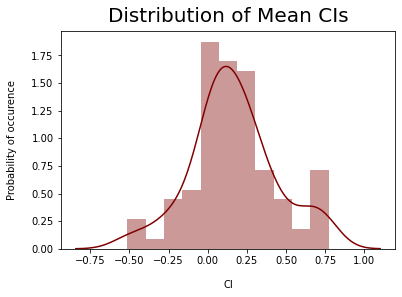

In [8]:
sns.distplot(summary_stats['Mean CI'], color="maroon")
plt.xlabel("CI", labelpad=14)
plt.ylabel("Probability of occurence", labelpad=14)
plt.title("Distribution of Mean CIs", y=1.015, fontsize=20);

In [9]:
cleaned_data['zscore'] = (cleaned_data.Chemotaxis - cleaned_data.Chemotaxis.mean())/cleaned_data.Chemotaxis.std(ddof=0)
cleaned_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,z-score,File Name,Plate ID,Slot,Well,zscore
0,1A,135,0.706422,1,NaN,0.207710,NPP_210319_POST_003,NPP_210319_007,1,A,1.647886
1,1A,181,0.607843,1,NaN,-1.087543,NPP_210322_POST_005,NPP_210322_017,1,A,1.347617
2,1A,226,0.757576,1,NaN,0.879833,NPP_210325_POST_004,NPP_210325_013,1,A,1.803699
3,1B,96,0.409836,2,NaN,-0.514872,NPP_210319_POST_003,NPP_210319_007,1,B,0.744492
4,1B,227,0.395833,2,NaN,-0.637651,NPP_210322_POST_005,NPP_210322_017,1,B,0.701840


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


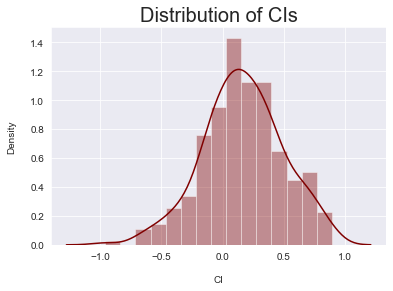

In [27]:
sns.set_style('darkgrid')
sns.distplot(cleaned_data['Chemotaxis'], color="maroon", kde=True)
plt.xlabel("CI", labelpad=14)
plt.ylabel("Density", labelpad=14)
plt.title("Distribution of CIs", y=1, fontsize=20);
plt.savefig('/Volumes/LaCie/_2021_03_screen/CI_dist.png')

In [26]:
values_plus_minus_one_z_score = len(cleaned_data[cleaned_data['z-score'].between(-1, 1)==True])
percent_values_plus_minus_one_z_score = values_plus_minus_one_z_score/len(cleaned_data)*100
percent_values_plus_minus_one_z_score

KeyError: 'z-score'

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


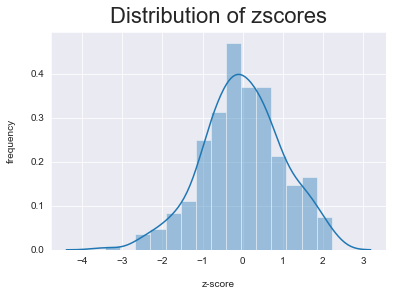

In [28]:
sns.set_style('darkgrid')
sns.distplot(cleaned_data['zscore'])
#cleaned_data['zscore'].hist(color='slategray')
plt.title("Distribution of zscores", y=1.015, fontsize=22)
plt.xlabel("z-score", labelpad=14)
plt.ylabel("frequency", labelpad=14);
plt.savefig('/Volumes/LaCie/_2021_03_screen/zscore_dist.png')

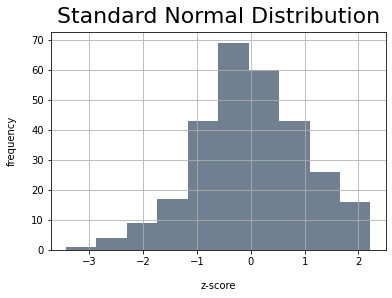

In [15]:
#sns.distplot(cleaned_data['Chemotaxis'])
cleaned_data['zscore'].hist(color='slategray')
plt.title("Standard Normal Distribution", y=1.015, fontsize=22)
plt.xlabel("z-score", labelpad=14)
plt.ylabel("frequency", labelpad=14);
plt.savefig('/Volumes/LaCie/_2021_03_screen/zscore_hist.png')

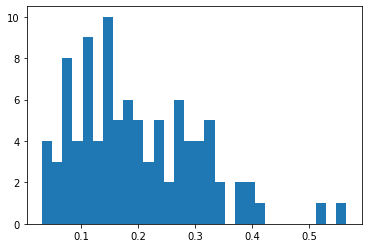

In [174]:
plt.hist(summary_stats['SD CI'], bins=30)
plt.show()

In [171]:
cv = pd.DataFrame({'Coefficient of Variance' : cleaned_data.groupby(['Compound'])['Chemotaxis'].std() / cleaned_data.groupby(['Compound'])['Chemotaxis'].mean().abs()})


In [175]:
merged_df = pd.merge(left=summary_stats, right=cv, left_on='Compound', right_on='Compound').reset_index(drop=True)
merged_df.head()

,Compound,Max Worms,Min Worms,Mean CI,SD CI,Compound Count,Coefficient of Variance
0,1,226,135,0.690614,0.076108,3,0.110203
1,2,227,96,0.468556,0.114049,3,0.243404
2,3,158,99,0.657173,0.199313,3,0.303289
3,4,263,201,0.070276,0.168868,3,2.402918
4,5,197,101,-0.357061,0.320388,3,0.897292


In [3]:
#merged_df.to_csv('/Volumes/LaCie/_2021_03_screen/2103_summarystats.csv')
merged_df = pd.read_csv('/Volumes/LaCie/_2021_03_screen/2103_summarystats.csv')

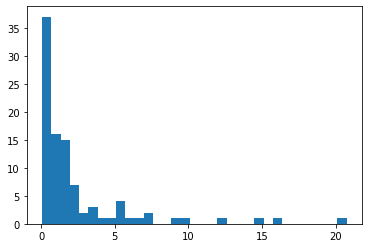

In [4]:
plt.hist(merged_df['Coefficient of Variance'], bins=33)
plt.show()

In [93]:
cleaned_data = cleaned_data.sort_values(by='Chemotaxis', ascending = False).reset_index(drop=True)

plot_order = cleaned_data['Compound'].unique().tolist()
cleaned_data.head()
# Use name column to label x ticks
#_ = ax.set_xticklabels(df.name.astype(str).values)

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well
0,1C,123,0.894737,7,NaN,NPP_210322_POST_004,NPP_210322_013,1,C
1,1B,205,0.882353,6,NaN,NPP_210322_POST_004,NPP_210322_013,1,B
2,3A,243,0.881818,25,NaN,NPP_210322_POST_005,NPP_210322_019,3,A
3,1C,136,0.881356,3,NaN,NPP_210325_POST_004,NPP_210325_013,1,C
4,3B,193,0.852273,26,NaN,NPP_210322_POST_005,NPP_210322_019,3,B


In [94]:
type(plot_order)

list

No handles with labels found to put in legend.


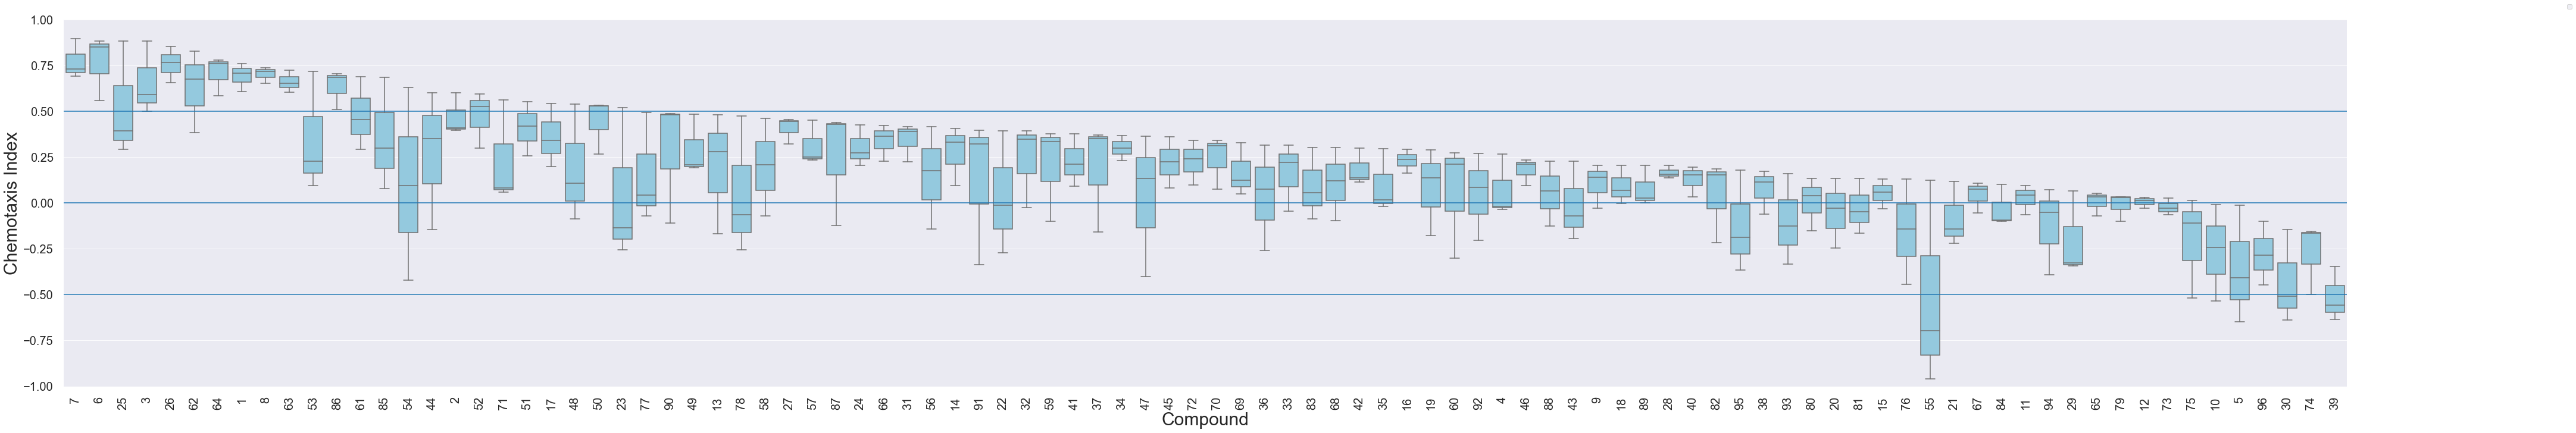

In [116]:
fig, ax = plt.subplots(figsize=(60, 10), constrained_layout=True)
sns.boxplot(x='Compound', y='Chemotaxis', ax=ax,
              data=cleaned_data, color='skyblue', dodge=False, order=plot_order)
ax.set_xlabel('Compound', fontsize=30)
ax.set_ylabel('Chemotaxis Index', fontsize=30)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
ax.tick_params(labelsize=20)
ax.axhline(.5)
ax.axhline(-.5)
ax.axhline(0)
sns.despine(offset=10)
plt.xticks(rotation=90)
plt.savefig('/Volumes/LaCie/_2021_03_screen/Spring21_allCompounds.png')

In [106]:
control_list = [5, 25, 40, 96, 54, 55, 62]
control_sumdat = merged_df[merged_df['Compound'].isin(control_list)].reset_index(drop=True)

In [4]:
#controls = cleaned_data[cleaned_data['Compound'].isin(control_list)].reset_index(drop=True)
#controls.to_csv('/Volumes/LaCie/_2021_03_screen/control_data.csv')
controls =pd.read_csv('/Volumes/LaCie/_2021_03_screen/control_data.csv')

In [1]:
control_order = ['DMSO', 'Null', '(-)-Carvone', '(+)-Carvone', '2-nonanone','Isoamyl Alcohol', 'Diacetyl' ] 

No handles with labels found to put in legend.


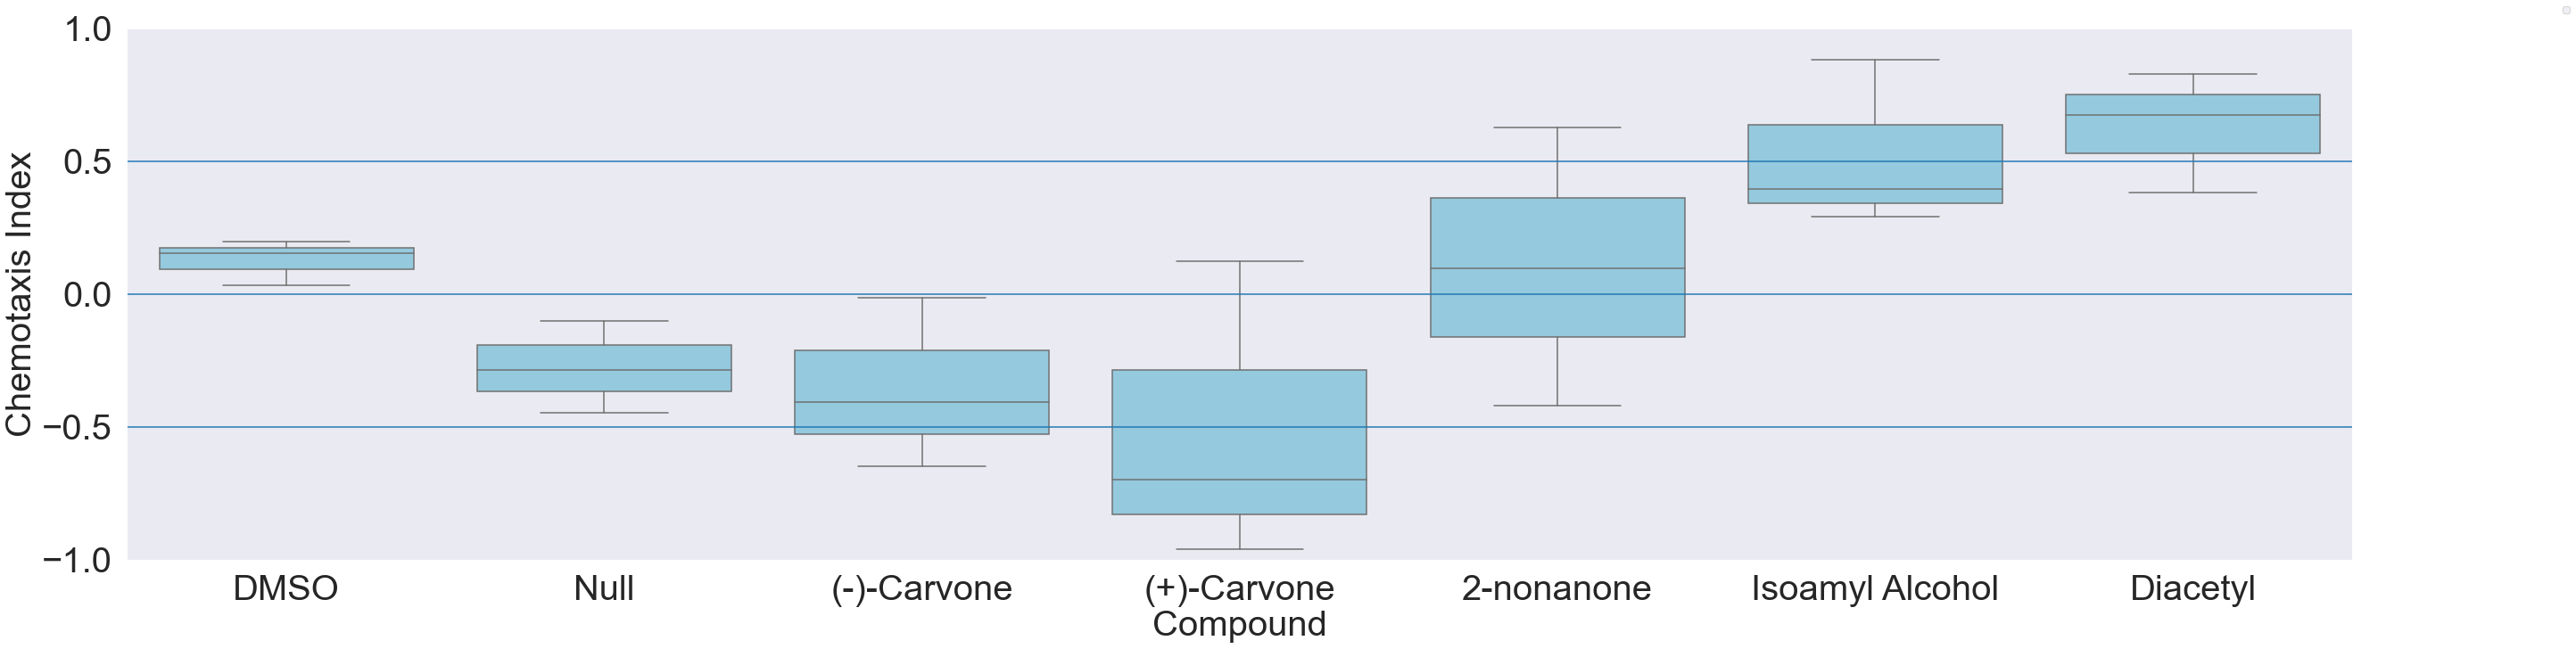

In [6]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(40, 10), constrained_layout=True)
sns.boxplot(x='Compound', y='Chemotaxis', ax=ax, color='skyblue',
              data=controls, order=control_order, dodge=False)
ax.set_xlabel('Compound', fontsize=40)
ax.set_ylabel('Chemotaxis Index', fontsize=40)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
ax.tick_params(labelsize=40)
ax.axhline(.5)
ax.axhline(-.5)
ax.axhline(0)
sns.despine(offset=10)
#plt.xticks(rotation=90)

plt.savefig('/Volumes/LaCie/_2021_03_screen/Controls.png')


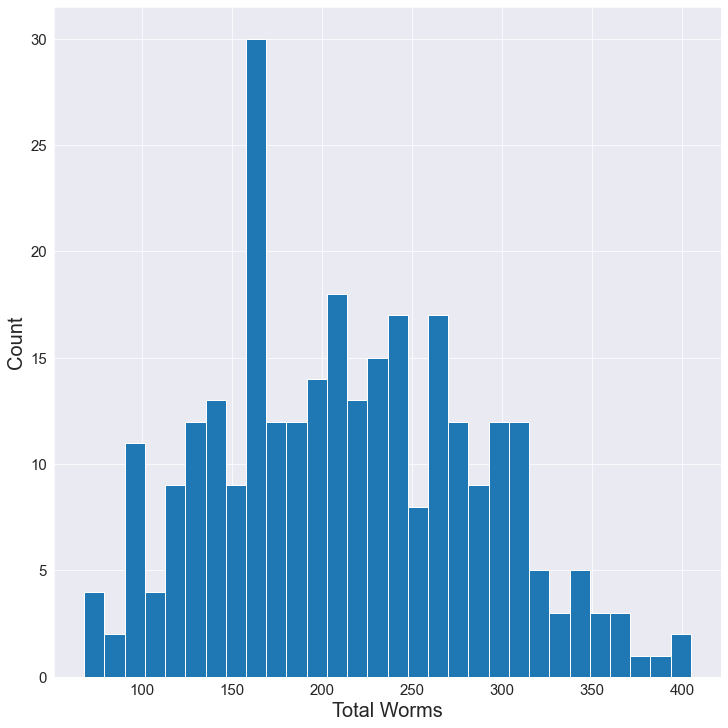

In [44]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
plt.hist(cleaned_data['Total Worms'], bins=30)
ax.set_xlabel('Total Worms', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('/Volumes/LaCie/_2021_03_screen/worm_dist.png')

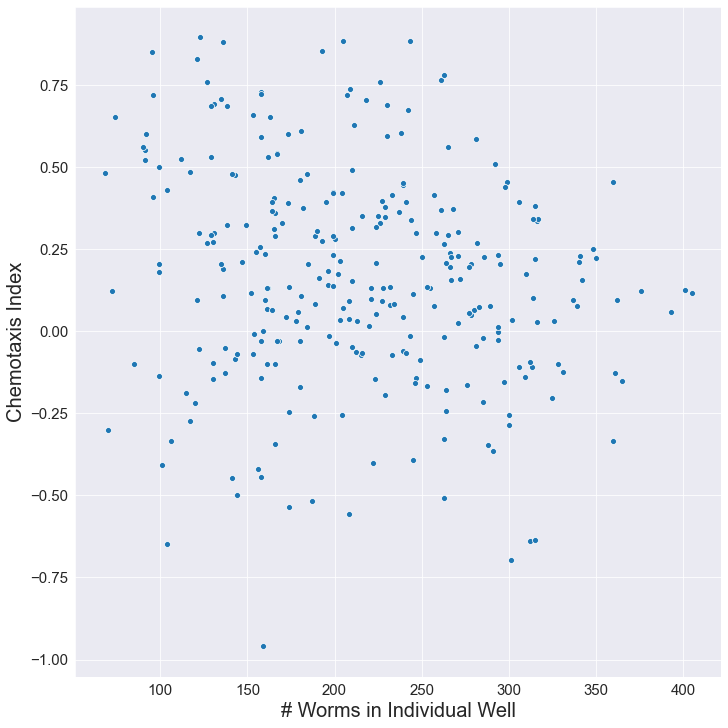

In [60]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
#plt.hist(merged_df['Coefficient of Variance'], bins=30)
sns.scatterplot(x=cleaned_data['Total Worms'], y=cleaned_data['Chemotaxis'])
ax.set_xlabel('# Worms in Individual Well', fontsize=20)
ax.set_ylabel('Chemotaxis Index', fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('/Volumes/LaCie/_2021_03_screen/CI_totalworms.png')

LinregressResult(slope=-0.0007762735243669539, intercept=0.3317100742736778, rvalue=-0.1705468270865535, pvalue=0.0036962333402102716, stderr=0.0002652030083250003)


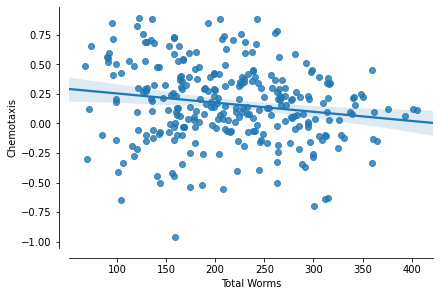

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
sns.regplot(x='Total Worms', y='Chemotaxis', ax=ax,
                     data=cleaned_data)
#ax.set_ylabel('# worms (machine)')
#ax.set_xlabel('# worms (manual)')
sns.despine(offset=10)
#fig.savefig(base_folder.joinpath('total_worms_man_vs_machine.pdf'))

fit_results = stats.linregress(
    cleaned_data['Total Worms'], cleaned_data['Chemotaxis'])
print(fit_results)

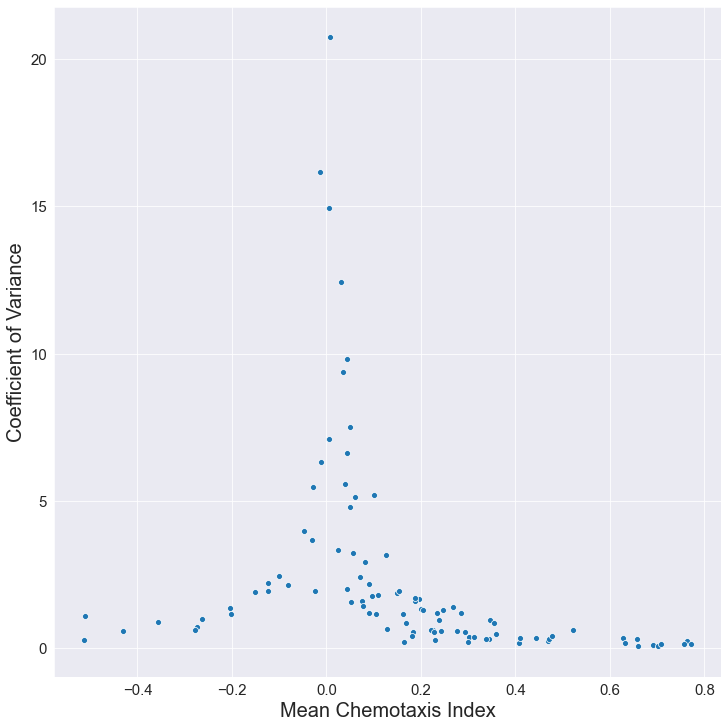

In [59]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
#plt.hist(merged_df['Coefficient of Variance'], bins=30)
sns.scatterplot(x=merged_df['Mean CI'], y=merged_df['Coefficient of Variance'])
ax.set_xlabel('Mean Chemotaxis Index', fontsize=20)
ax.set_ylabel('Coefficient of Variance', fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('/Volumes/LaCie/_2021_03_screen/CV_CImeans.png')

In [17]:
print(len(blind))

288


LinregressResult(slope=-3.900450937323759, intercept=3.0221190312320454, rvalue=-0.2991494978459995, pvalue=0.0030686462866198025, stderr=1.283231091889434)


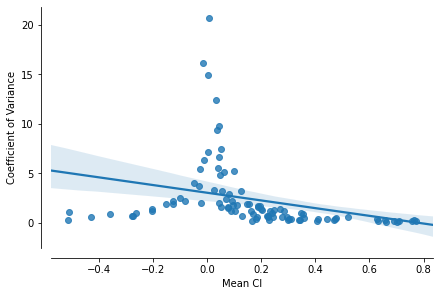

In [24]:
fig, ax = plt.subplots(constrained_layout=True)
sns.regplot(x='Mean CI', y='Coefficient of Variance', ax=ax,
                     data=merged_df)
#ax.set_ylabel('# worms (machine)')
#ax.set_xlabel('# worms (manual)')
sns.despine(offset=10)
#fig.savefig(base_folder.joinpath('total_worms_man_vs_machine.pdf'))

fit_results = stats.linregress(
    merged_df['Mean CI'], merged_df['Coefficient of Variance'])
print(fit_results)

In [7]:
#blind.to_csv('/Volumes/LaCie/_2021_03_screen/2103_data_unblinded.csv')

### Cleaning Fall data to combine with new  screen for CV analysis

In [32]:
fall20_assay_data = pd.read_csv('/Volumes/LaCie/_2020_11_screen/_2020_11_automated_analysis/2020_11.csv').reset_index(drop=True)
fall20_assay_data.head()

,Unnamed: 0,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID
0,0,1A,129,0.700000,NaN,NaN,NPP_201030_01_fin017,NaN
1,1,1B,198,0.440000,NaN,NaN,NPP_201030_01_fin017,NaN
2,2,1C,146,0.840580,NaN,NaN,NPP_201030_01_fin017,NaN
3,3,1D,159,0.907895,NaN,NaN,NPP_201030_01_fin017,NaN
4,4,2A,283,0.057915,NaN,NaN,NPP_201030_01_fin017,NaN


In [33]:
fall20_assay_data['File Name'] = fall20_assay_data['File Name'].str[:-3]
fall20_assay_data.head()

,Unnamed: 0,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID
0,0,1A,129,0.700000,NaN,NaN,NPP_201030_01_fin,NaN
1,1,1B,198,0.440000,NaN,NaN,NPP_201030_01_fin,NaN
2,2,1C,146,0.840580,NaN,NaN,NPP_201030_01_fin,NaN
3,3,1D,159,0.907895,NaN,NaN,NPP_201030_01_fin,NaN
4,4,2A,283,0.057915,NaN,NaN,NPP_201030_01_fin,NaN


In [34]:
image_data = pd.read_csv('/Volumes/LaCie/_2020_11_screen/ImageData_Fall20.csv')

In [35]:
image_data.rename(columns={
                       "Image file name:": 'filename',
                       'Is this the pre or post assay image?': 'pre_fin',
                      'Plate number in slot 1:': '1',
                       'Plate number in slot 2:': '2',
                       'Plate number in slot 3:': '3',
                       'Plate number in slot 4:': '4',}, inplace=True)
image_data.head()

,Timestamp,Scanner Number:,filename,1,2,3,4
0,10/29/2020 16:52:03,3,NPP_201102_01_pre.tif,NPP_201102_001,NPP_201102_002,NPP_201102_003,NPP_201102_004
1,10/29/2020 16:59:16,4,NPP_201030_01_pre.tif,NPP_201030_001,NPP_201030_002,NPP_201030_003,NPP_201030_004
2,10/29/2020 17:00:22,3,NPP_201102_01_pre.tiff,NPP_201102_005,NPP_201102_006,NPP_201102_007,NPP_201102_008
3,10/29/2020 17:01:35,3,NPP_201102_03_pre.tiff,NPP_201102_009,NPP_201102_010,NaN,NaN
4,10/29/2020 17:06:43,4,NPP_201030_02_pre.tif,NPP_201030_005,NPP_201030_006,NPP_201030_007,NPP_201030_008


In [36]:
image_data['filename'] = image_data['filename'].str[:17]
image_data.head()

,Timestamp,Scanner Number:,filename,1,2,3,4
0,10/29/2020 16:52:03,3,NPP_201102_01_pre,NPP_201102_001,NPP_201102_002,NPP_201102_003,NPP_201102_004
1,10/29/2020 16:59:16,4,NPP_201030_01_pre,NPP_201030_001,NPP_201030_002,NPP_201030_003,NPP_201030_004
2,10/29/2020 17:00:22,3,NPP_201102_01_pre,NPP_201102_005,NPP_201102_006,NPP_201102_007,NPP_201102_008
3,10/29/2020 17:01:35,3,NPP_201102_03_pre,NPP_201102_009,NPP_201102_010,NaN,NaN
4,10/29/2020 17:06:43,4,NPP_201030_02_pre,NPP_201030_005,NPP_201030_006,NPP_201030_007,NPP_201030_008


In [37]:
def add_pid(row, image_data):
    slot_id = row['WellNo'][0]
    pid = image_data.loc[
       image_data['filename']==row['File Name']][slot_id]
    return pid.values[0]


fall20_assay_data['Plate ID'] = fall20_assay_data.apply(
    lambda row: add_pid(row, image_data), axis=1)


In [38]:
#fall20_blind = pd.read_csv('/Volumes/LaCie/_2020_11_screen/unblind.csv')
fall20_assay_data.head()

,Unnamed: 0,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID
0,0,1A,129,0.700000,NaN,NaN,NPP_201030_01_fin,NPP_201030_001
1,1,1B,198,0.440000,NaN,NaN,NPP_201030_01_fin,NPP_201030_001
2,2,1C,146,0.840580,NaN,NaN,NPP_201030_01_fin,NPP_201030_001
3,3,1D,159,0.907895,NaN,NaN,NPP_201030_01_fin,NPP_201030_001
4,4,2A,283,0.057915,NaN,NaN,NPP_201030_01_fin,NPP_201030_002


In [20]:
Fall20_blinding_data = pd.read_csv('/Volumes/LaCie/_2020_11_screen/unblind.csv')

In [21]:
def add_fall_comp(row, fall20_blind):
    well_id = row['WellNo'][1]
    pid = row['Plate ID']
    pid_well = str(pid+well_id)
    compound = fall20_blind.loc[
       pid_well==fall20_blind['Plate_well_id']]['Compound']
    #print(compound.values[0])
    return compound.values[0]


fall20_assay_data['Compound'] = fall20_assay_data.apply(
    lambda row: add_fall_comp(row, Fall20_blinding_data), axis=1)
fall20_assay_data.head()

NameError: name 'fall20_assay_data' is not defined

In [47]:
#fall20_assay_data.to_csv('/Volumes/LaCie/_2020_11_screen/Fall20_analysis_ub.csv')

In [10]:
fall20_assay_data = pd.read_csv('/Volumes/LaCie/_2020_11_screen/Fall20_analysis_ub.csv')
fall20_assay_data.head()

,Unnamed: 0,Unnamed: 0.1,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID
0,0,0,1A,129,0.700000,Isobutanol/2-Methyl-1-propanol,NaN,NPP_201030_01_fin,NPP_201030_001
1,1,1,1B,198,0.440000,Cadaverine,NaN,NPP_201030_01_fin,NPP_201030_001
2,2,2,1C,146,0.840580,EtOH (control),NaN,NPP_201030_01_fin,NPP_201030_001
3,3,3,1D,159,0.907895,2-Methyl-1-butanol,NaN,NPP_201030_01_fin,NPP_201030_001
4,4,4,2A,283,0.057915,2-butanone,NaN,NPP_201030_01_fin,NPP_201030_002


In [11]:
fall20_assay_data = fall20_assay_data.loc[:, ~fall20_assay_data.columns.str.contains('^Unnamed')]
fall20_assay_data = fall20_assay_data.drop(columns=['Strain'])
fall20_assay_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,File Name,Plate ID
0,1A,129,0.700000,Isobutanol/2-Methyl-1-propanol,NPP_201030_01_fin,NPP_201030_001
1,1B,198,0.440000,Cadaverine,NPP_201030_01_fin,NPP_201030_001
2,1C,146,0.840580,EtOH (control),NPP_201030_01_fin,NPP_201030_001
3,1D,159,0.907895,2-Methyl-1-butanol,NPP_201030_01_fin,NPP_201030_001
4,2A,283,0.057915,2-butanone,NPP_201030_01_fin,NPP_201030_002


In [12]:

total_worms = fall20_assay_data.loc[(fall20_assay_data['Total Worms'] >= 100) & (fall20_assay_data['Total Worms'] <= 300)]
total_worms.head()  

,WellNo,Total Worms,Chemotaxis,Compound,File Name,Plate ID
1,1B,198,0.440000,Cadaverine,NPP_201030_01_fin,NPP_201030_001
3,1D,159,0.907895,2-Methyl-1-butanol,NPP_201030_01_fin,NPP_201030_001
4,2A,283,0.057915,2-butanone,NPP_201030_01_fin,NPP_201030_002
5,2B,286,-0.183673,Lemongrass,NPP_201030_01_fin,NPP_201030_002
6,2C,184,0.329193,H2O(controll),NPP_201030_01_fin,NPP_201030_002


In [13]:
total_worms['freq'] = total_worms.groupby('Compound')['Compound'].transform('count')
total_worms


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,WellNo,Total Worms,Chemotaxis,Compound,File Name,Plate ID,freq
1,1B,198,0.440000,Cadaverine,NPP_201030_01_fin,NPP_201030_001,5
3,1D,159,0.907895,2-Methyl-1-butanol,NPP_201030_01_fin,NPP_201030_001,3
4,2A,283,0.057915,2-butanone,NPP_201030_01_fin,NPP_201030_002,5
5,2B,286,-0.183673,Lemongrass,NPP_201030_01_fin,NPP_201030_002,4
6,2C,184,0.329193,H2O(controll),NPP_201030_01_fin,NPP_201030_002,4
7,2D,242,0.112108,GENTISIC ACID,NPP_201030_01_fin,NPP_201030_002,4
8,3A,213,-0.034091,SINOMENINE,NPP_201030_01_fin,NPP_201030_003,6
9,3B,183,0.309524,Peoniflorin,NPP_201030_01_fin,NPP_201030_003,3
10,3C,218,0.401070,Piperine,NPP_201030_01_fin,NPP_201030_003,6
11,3D,246,0.203463,Galantamine,NPP_201030_01_fin,NPP_201030_003,4
